In [1]:
from dataclasses import asdict

import torch
from matplotlib import pyplot as plt

from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

from asap.engine.actions import *
from asap.training.environment.environment import AsapEnvironmentTwoPlayer
from asap.training.scenarios.mosquito_upgrade_to_superduck_scenario.optimal_adversary import OpponentOptimalMosquitoUpgradeToSuperduckScenario
from asap.training.scenarios.mosquito_upgrade_to_superduck_scenario.settings import mosquito_to_superduck_game_settings
from asap.training.environment.observation_space import get_observation_dim_names
from asap.training.environment.observation_space import make_full_observation_space


In [4]:
model = MaskablePPO.load("/home/dean/src/asap/training/runs/2024-10-10/04-33-30/best_model", device='cpu')
policy_model = model.policy

# Sample some observations from the environment
opponent = OpponentOptimalMosquitoUpgradeToSuperduckScenario({})
env = AsapEnvironmentTwoPlayer(mosquito_to_superduck_game_settings, opponent, use_flat_observations=True, observe_opponent_after_battle=False, verbose=0)
env = ActionMasker(env, env.mask_fn)

opponent.action_map_inverse = env.action_map_inverse

obs, _  = env.reset()

# Collect a batch of observations
observations, actions = [], []
for _ in range(20):
    action, _ = model.predict(obs, deterministic=True, action_masks=env.action_masks())
    actions.append(action)
    obs, reward, terminated, truncated, _ = env.step(action)
    observations.append(obs)
    if terminated:
        obs, _ = env.reset()

observations = torch.tensor(observations, dtype=torch.float32, device="cpu")

In [5]:
from pprint import pprint

pprint([env.action_map[int(action)] for action in actions])

[ActionBuyAndPlacePet(shop_index=1, pet_position=0),
 ActionBuyAndMergePet(shop_index=0, pet_position=0),
 ActionBuyAndMergePet(shop_index=2, pet_position=0),
 ActionSellPet(pet_position=0),
 ActionBuyAndPlacePet(shop_index=0, pet_position=0),
 ActionFreezeFood(shop_index=0),
 ActionSwapPets(position_a=1, position_b=0),
 ActionSwapPets(position_a=1, position_b=0),
 ActionSwapPets(position_a=1, position_b=0),
 ActionEndTurn(),
 ActionBuyAndPlacePet(shop_index=1, pet_position=0),
 ActionBuyAndMergePet(shop_index=0, pet_position=0),
 ActionBuyFood(shop_index=0, pet_position=1),
 ActionSwapPets(position_a=1, position_b=0),
 ActionRefreshShop(),
 ActionFreezePet(shop_index=2),
 ActionUnfreezePet(shop_index=2),
 ActionEndTurn(),
 ActionBuyAndPlacePet(shop_index=1, pet_position=0),
 ActionBuyAndMergePet(shop_index=0, pet_position=0)]


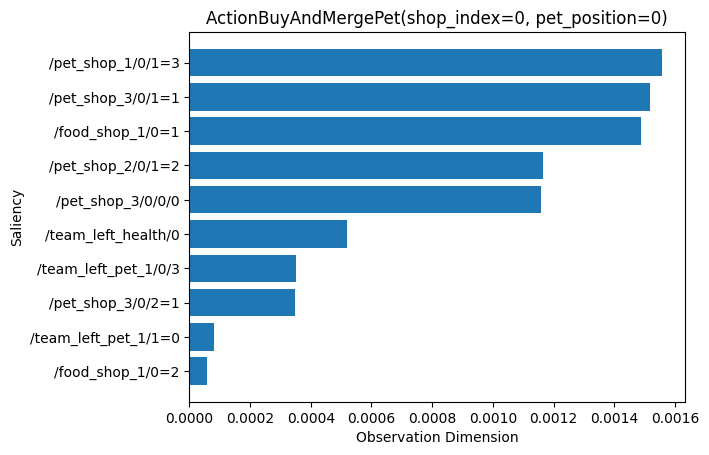

In [46]:
action = ActionBuyAndMergePet(0, 0)
action_idx = env.action_map_inverse[action]

obs_tensor = torch.tensor(obs).float().unsqueeze(0).requires_grad_(True)
action_dist = model.policy.get_distribution(obs_tensor)
loss = -action_dist.log_prob(torch.tensor([action_idx]))
loss.backward()
saliency = obs_tensor.grad.data.abs().squeeze().numpy()

full_observation_space = make_full_observation_space(game_settings=env.game_settings, observe_opponent_after_battle=env.observe_opponent_after_battle)
observation_dim_names = get_observation_dim_names(env.nested_observation_space)

saliency, labels = zip(*sorted(list(zip(saliency, observation_dim_names))))

plt.barh(labels[:10], saliency[:10])
plt.title(str(action))
plt.ylabel("Saliency")
plt.xlabel("Observation Dimension")
plt.show()


In [24]:
len(saliency)

91

In [25]:
len(observation_dim_names)

91